<a href="https://colab.research.google.com/github/bonardolubis/MachineLearningTasks/blob/main/TaskWeek6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tugas Minggu ke-6

Nama : Bonardo Lubis

NPM : 2006568784

Original Code : https://www.kaggle.com/code/yossefmohammed/twitter-sentiment-analysis-with-lstm

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')

print('Data source import complete.')


100%|██████████| 1.99M/1.99M [00:01<00:00, 1.89MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(jp797498e_twitter_entity_sentiment_analysis_path)

/root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


In [ ]:
import pandas as pd

- Lod the training data

In [ ]:
training = pd.read_csv("/root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2/twitter_training.csv")
test = pd.read_csv("/root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2/twitter_validation.csv")

In [ ]:
training

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


- load the testing data

In [ ]:
test

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


- Add headers for the columns in each dataframe:

In [ ]:
test.columns = ['Header1', 'company','labels','text']
training.columns = ['Header1', 'company','labels','text']

In [ ]:
print(training)
print("---------------------------------------------------------------------")
print(test)

       Header1      company    labels  \
0         2401  Borderlands  Positive   
1         2401  Borderlands  Positive   
2         2401  Borderlands  Positive   
3         2401  Borderlands  Positive   
4         2401  Borderlands  Positive   
...        ...          ...       ...   
74676     9200       Nvidia  Positive   
74677     9200       Nvidia  Positive   
74678     9200       Nvidia  Positive   
74679     9200       Nvidia  Positive   
74680     9200       Nvidia  Positive   

                                                    text  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized that my Mac wi

- Delete unneeded columns

In [ ]:
training.drop(columns=["Header1","company"],inplace=True)
test.drop(columns=["Header1","company"],inplace=True)

In [ ]:
training.head()

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [ ]:
test.head()

,labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


- Add the two data frame in one datarame

In [ ]:
sentiment=pd.concat([training,test],ignore_index=True)
sentiment

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
75675,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75676,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677,Positive,Today sucked so it’s time to drink wine n play...
75678,Positive,Bought a fraction of Microsoft today. Small wins.


- Check for cleaning data

In [ ]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  75680 non-null  object
 1   text    74994 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
sentiment.isnull().sum()

,0
labels,0
text,686


In [ ]:
sentiment.dropna(inplace=True)
sentiment.isnull().sum()

,0
labels,0
text,0


In [ ]:
sentiment.duplicated().sum()

4743

In [ ]:
sentiment.drop_duplicates(inplace=True)
sentiment.duplicated().sum()

0

- preprocessing the text n the data:

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...


Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/README  
  inflating: /kaggle/w

- this function for cleaning the text:

In [ ]:

def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text

    text = re.sub(r'\W', ' ', str(text)) # Remove all the special characters from text

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [ ]:
x=sentiment.drop('labels',axis=1)
y=sentiment.labels

In [ ]:
texts=list(x['text'])

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
cleaned_text = [process_text(text) for text in texts]

In [ ]:
print(cleaned_text[:10])

[['coming', 'border', 'kill'], ['getting', 'borderland', 'kill'], ['coming', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'couple', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'picture', 'compared', 'creation', 'made', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, y, test_size=0.2, random_state=42)

- prepare the data to the model:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


the size of vocab = 24048


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)



In [ ]:
y.value_counts()

,count
labels,
Negative,21329
Positive,19270
Neutral,17281
Irrelevant,12371


- build the model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Input,GlobalMaxPooling1D,Dropout,Bidirectional
from tensorflow.keras.models import Model
from keras import optimizers
import numpy as np
D=100
inputt=Input(shape=(maxlen,))

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001  # Set your desired learning rate here
x=Embedding(v+1,D)(inputt)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(150))(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputt, x)

# Define optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
import tensorflow as tf

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)
history = model.fit(X_train, y_train_one_hot, epochs=40, validation_data=(X_test, y_test_one_hot))


Epoch 1/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.3590 - loss: 1.3202 - val_accuracy: 0.5763 - val_loss: 1.0313
Epoch 2/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.5963 - loss: 0.9784 - val_accuracy: 0.6637 - val_loss: 0.8448
Epoch 3/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.7009 - loss: 0.7671 - val_accuracy: 0.7343 - val_loss: 0.7054
Epoch 4/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.7737 - loss: 0.6001 - val_accuracy: 0.7798 - val_loss: 0.5914
Epoch 5/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.8160 - loss: 0.4935 - val_accuracy: 0.8060 - val_loss: 0.5215
Epoch 6/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8390 - loss: 0.4319 - val_accuracy: 0.8255 - val_loss: 0.4764
Epoch 7/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8568 - loss: 0.3833 - val_accuracy: 0.8282 - val_loss: 0.4648
Epoch 8/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8683 -

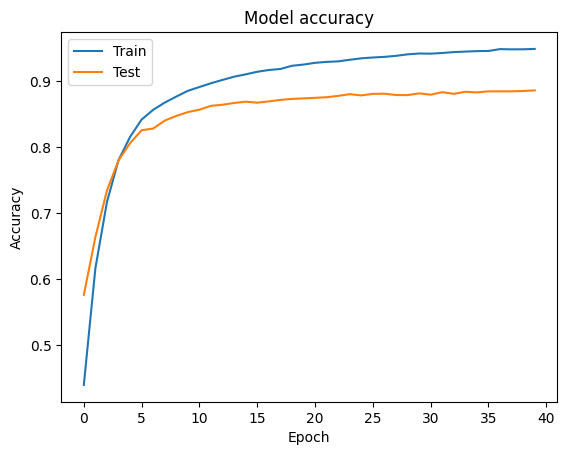

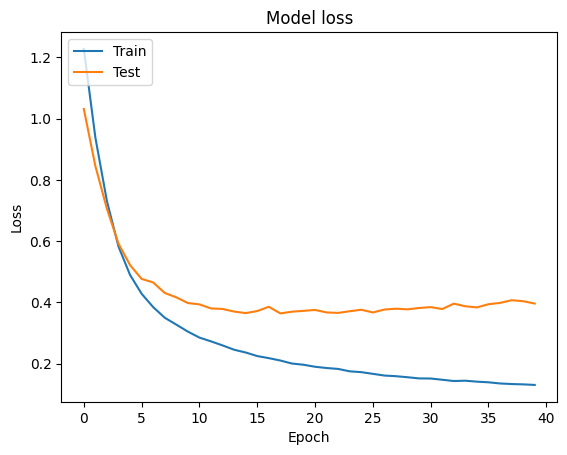

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8871 - loss: 0.3903
Test Loss: 0.3959183692932129
Test Accuracy: 0.8858444094657898


440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


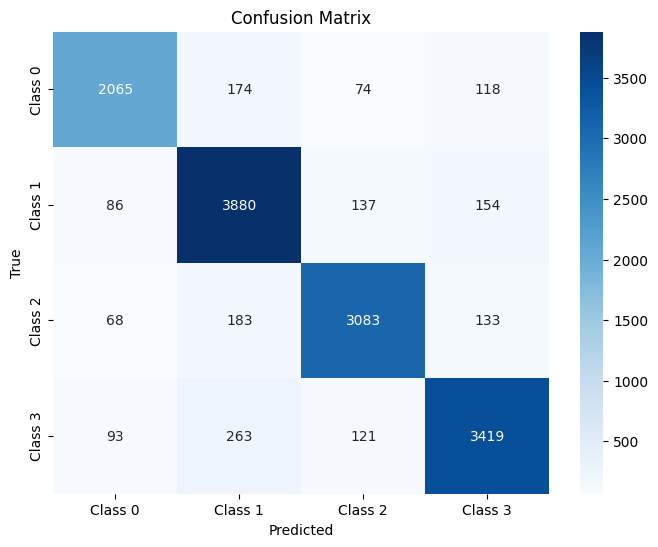

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
